## Part 0. Data Preparation

The data for this PROJECT are plant images at different resolutions captured with a variety of cameras. There are images showing plants with approximatelty 1,2,3,4 and 6 leafs. The images are part of a Leaf counting dataset by Teimouri et al. [1] which can be downloaded from the Aarhus University, Denmark:

<a href="https://vision.eng.au.dk/leaf-counting-dataset/">Leaf counting dataset</a> 

In [30]:
#Importing libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from random import sample

#Keras
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization,Dropout 
from pathlib import Path

#sklearn 
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay

In [2]:
# Prepare your dataset here
def load_images(folders):
    x = []
    y = []
    for i in os.listdir(folders):
        folder = os.path.join(folders,i)
        for file in os.listdir(folder):
            img = cv2.imread(os.path.join(folder,file))
            if img is not None:
                x.append(img)
                y.append(int(i))
    return x,y   

In [3]:
x_train,y_train = load_images('D:/DEBI/Uottawa/Second term/Computer vision/Assignments/Assignment 3/training')

In [4]:
x_test,y_test = load_images('D:/DEBI/Uottawa/Second term/Computer vision/Assignments/Assignment 3/testing')

In [5]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

c:\Users\EGYPT_LAPTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\construction.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


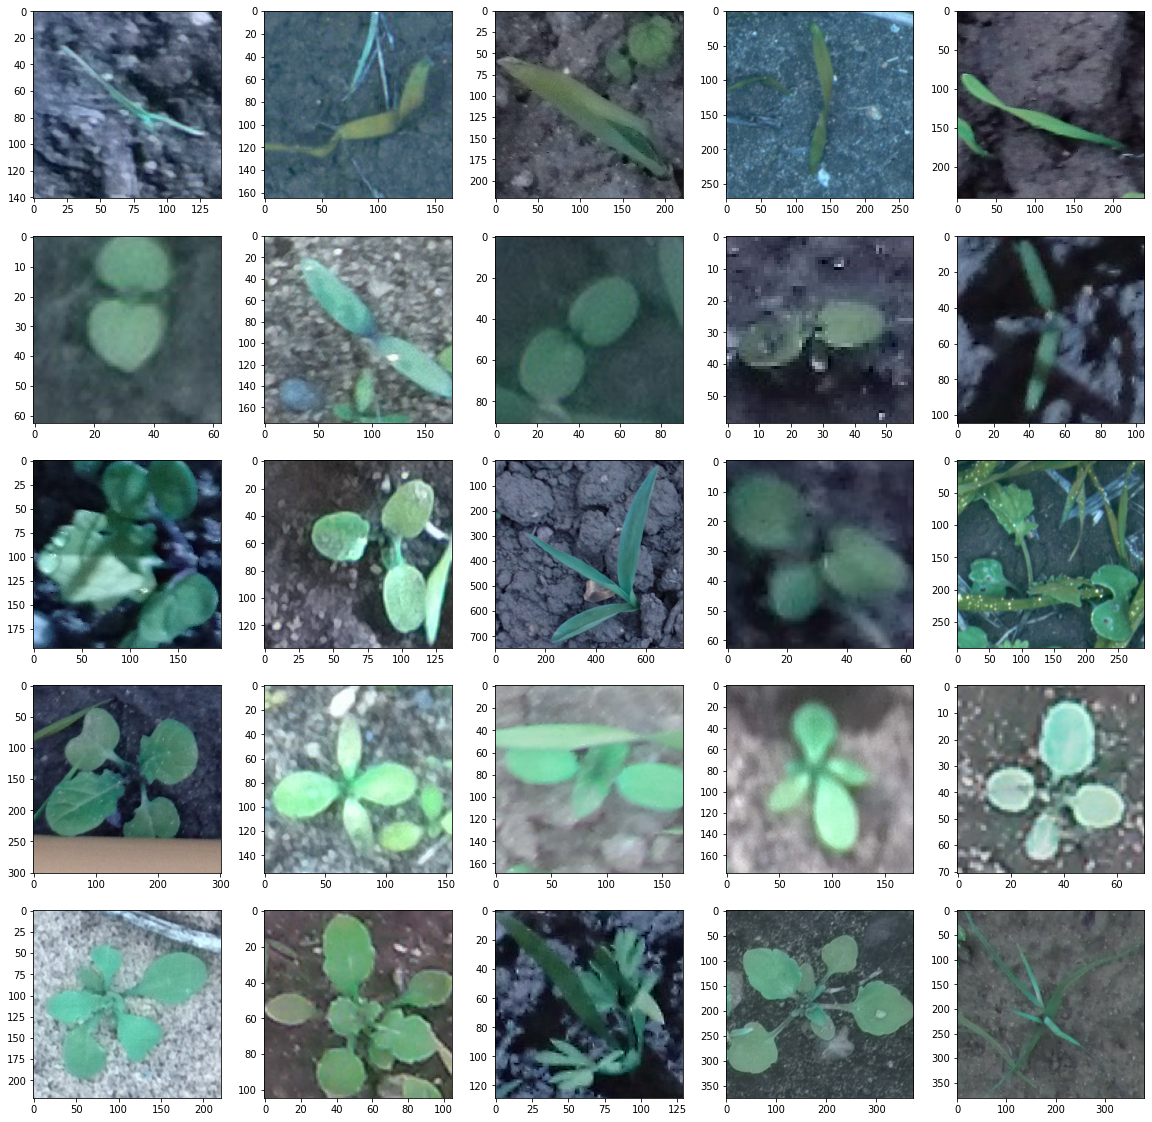

In [6]:
#Visualize the dataset
def dispImg(imgs,label,n_sample):
    sample_img = {}
    l = 5
    for i in [1,2,3,4,6]:
        idx = np.where(label == i)[0]
        img = imgs.iloc[idx]
        sample_img[i] = sample(list(img[0]),n_sample) 
    fig, ax = plt.subplots(l,n_sample,figsize=(20, 20))
    k=0
    for i in [1,2,3,4,6]:
        for j in range(n_sample):
            ax[k,j].imshow(sample_img[i][j])
        k+=1
        
dispImg(x_train,y_train,5)

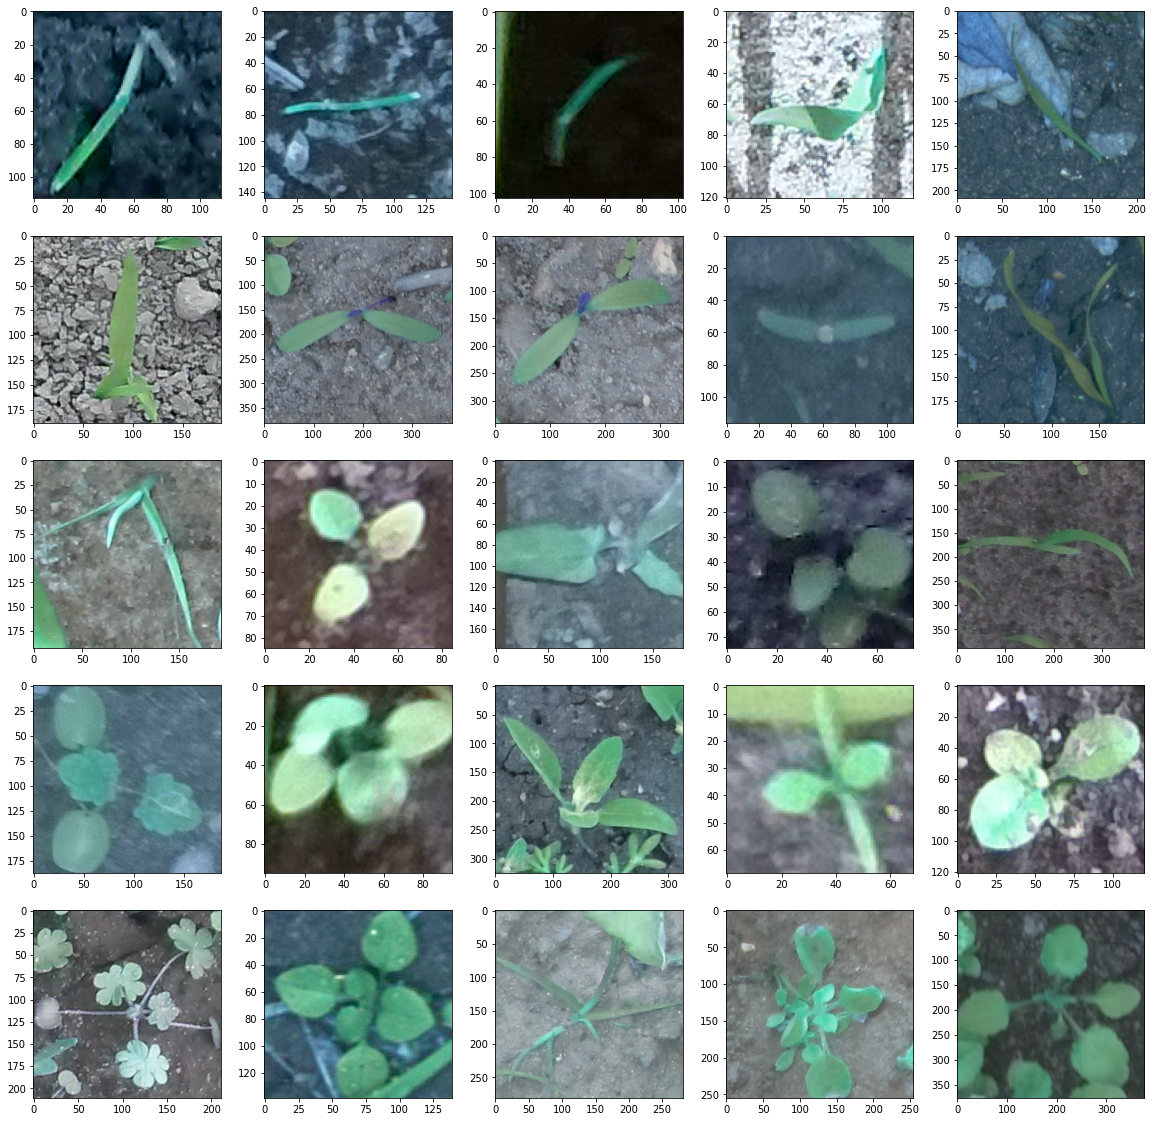

In [7]:
dispImg(x_test,y_test,5)

## Part 1a. Transfer Learning - Classification Network 

In [8]:
# Resize images
def resizeImg(x):
    resize = []
    for i in x:
        img = cv2.resize(i, (128,128), interpolation = cv2.INTER_AREA)
        resize.append(img)
    return resize
x_train =resizeImg(x_train[0])
x_test = resizeImg(x_test[0])

In [9]:
x_train = np.array(x_train)
x_test = np.array(x_test)
print(x_train.shape)
print(x_test.shape)

(900, 128, 128, 3)
(100, 128, 128, 3)


In [10]:
#Split train data into train set and validation set
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.2,random_state=42)

In [11]:
import tensorflow
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes=7)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes=7)
y_val = tensorflow.keras.utils.to_categorical(y_val, num_classes=7)


In [12]:
# Uning VGG16 application
vgg_16 = VGG16(include_top=False,weights='imagenet', input_shape=(128,128,3))
print(vgg_16.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [16]:
x = vgg_16.layers[6].output
x = Conv2D(300,3,padding="same",activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(512,3,padding="same",activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(500, activation='relu')(x)
x = Dense(7, activation='softmax')(x)
vgg_model = Model(inputs=vgg_16.input, outputs=x)

In [17]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [19]:
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
history = vgg_model.fit(x_train, y_train, batch_size=32, epochs=50, verbose=1,validation_data=(x_val, y_val))

Epoch 1/50
23/23 [==============================] - 102s 4s/step - loss: 1.7287 - accuracy: 0.2194 - val_loss: 1.6292 - val_accuracy: 0.2700
Epoch 2/50
23/23 [==============================] - 107s 5s/step - loss: 1.6215 - accuracy: 0.2639 - val_loss: 1.6310 - val_accuracy: 0.2500
Epoch 3/50
23/23 [==============================] - 107s 5s/step - loss: 1.5194 - accuracy: 0.3083 - val_loss: 1.6910 - val_accuracy: 0.2000
Epoch 4/50
23/23 [==============================] - 103s 4s/step - loss: 1.4356 - accuracy: 0.3597 - val_loss: 1.9116 - val_accuracy: 0.2200
Epoch 5/50
23/23 [==============================] - 109s 5s/step - loss: 1.4113 - accuracy: 0.3611 - val_loss: 2.0134 - val_accuracy: 0.2400
Epoch 6/50
23/23 [==============================] - 107s 5s/step - loss: 1.3075 - accuracy: 0.4292 - val_loss: 1.9903 - val_accuracy: 0.2500
Epoch 7/50
23/23 [==============================] - 109s 5s/step - loss: 1.2768 - accuracy: 0.4500 - val_loss: 2.7048 - val_accuracy: 0.1800
Epoch 8/50
23

In [13]:
# for plot accuracy curve
def plt_acc(train_acc,test_acc):
    plt.plot(train_acc)
    plt.plot(test_acc)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [14]:
# for plot loss curve
def plt_loss(train_loss,test_loss):
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

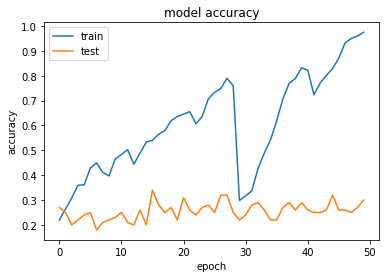

In [22]:
plt_acc(history.history['accuracy'],history.history['val_accuracy'])

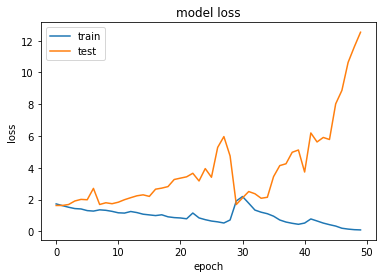

In [23]:
plt_loss(history.history['loss'],history.history['val_loss'])

In [26]:
#predicting
y_pred_test = vgg_model.predict(x_test)
y_pred_train = vgg_model.predict(x_train)
y_pred_val = vgg_model.predict(x_val)

6/6 [==============================] - 6s 1s/step


In [37]:
#Evaluating
def evaluate(y,y_pred):
    cm = confusion_matrix(y.argmax(axis = -1),y_pred.argmax(axis = -1))
    cr = classification_report(y.argmax(axis = -1),y_pred.argmax(axis = -1))
    print(cr)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot()
    return cm

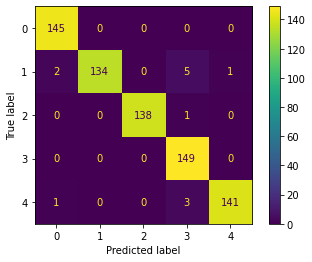

In [34]:
cm = evaluate(y_train,y_pred_train)

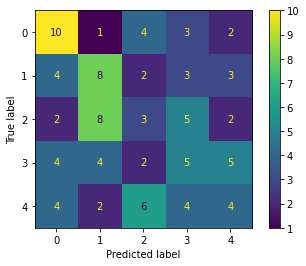

In [35]:
cm = evaluate(y_test,y_pred_test)

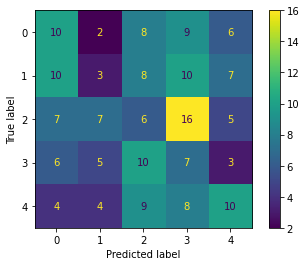

In [36]:
cm = evaluate(y_val,y_pred_val)

## Part 1b. Transfer Learning - Regression Reformulation

In [16]:
# Convert targent form discrete to continuous
mapping ={1:0,2:1,3:2,4:3,6:4}
y_train_ = y_train.argmax(axis = -1)
y_test_ = y_test.argmax(axis = -1)
y_val_ = y_val.argmax(axis = -1)
y_train_new = np.array([mapping[i] for i in y_train_]).astype(float)
y_val_new = np.array([mapping[i] for i in y_val_]).astype(float)
y_test_new = np.array([mapping[i] for i in y_test_]).astype(float)

In [17]:
# vgg_16 = VGG16(include_top=False,weights='imagenet', input_shape=(128,128,3))
# print(vgg_16.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [52]:
for layer in vgg_16.layers:
    layer.trainable = False
x = vgg_16.layers[6].output
x = Conv2D(300,3,padding="same",activation='tanh')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(512,3,padding="same",activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(1,3,activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
#x = Dense(50, activation='relu')(x)
x = Dense(1, activation='relu6')(x)
vgg_model = Model(inputs=vgg_16.input, outputs=x)

In [53]:
#Write your code here
vgg_model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
history = vgg_model.fit(x_train, y_train_new, batch_size=32, epochs=50, verbose=1,validation_data=(x_val, y_val_new))

Epoch 1/50
23/23 [==============================] - 37s 2s/step - loss: 6.0076 - accuracy: 0.2014 - val_loss: 5.6943 - val_accuracy: 0.1944
Epoch 2/50
23/23 [==============================] - 48s 2s/step - loss: 5.9209 - accuracy: 0.2014 - val_loss: 5.6050 - val_accuracy: 0.1944
Epoch 3/50
23/23 [==============================] - 54s 2s/step - loss: 5.8302 - accuracy: 0.2014 - val_loss: 5.5204 - val_accuracy: 0.1944
Epoch 4/50
23/23 [==============================] - 46s 2s/step - loss: 5.7430 - accuracy: 0.2014 - val_loss: 5.4348 - val_accuracy: 0.1944
Epoch 5/50
23/23 [==============================] - 54s 2s/step - loss: 5.6567 - accuracy: 0.2014 - val_loss: 5.3509 - val_accuracy: 0.1944
Epoch 6/50
23/23 [==============================] - 51s 2s/step - loss: 5.5726 - accuracy: 0.2014 - val_loss: 5.2697 - val_accuracy: 0.1944
Epoch 7/50
23/23 [==============================] - 57s 2s/step - loss: 5.4893 - accuracy: 0.2014 - val_loss: 5.1909 - val_accuracy: 0.1944
Epoch 8/50
23/23 [==

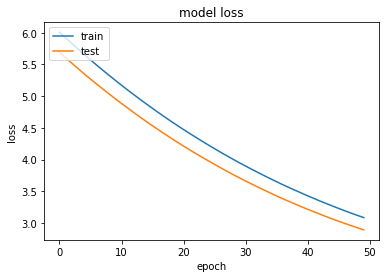

In [54]:
plt_loss(history.history['loss'],history.history['val_loss'])

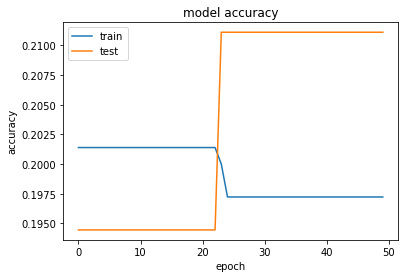

In [55]:
plt_acc(history.history['accuracy'],history.history['val_accuracy'])

In [56]:
y_pred_test = vgg_model.predict(x_test)
y_pred_train = vgg_model.predict(x_train)
y_pred_val = vgg_model.predict(x_val)

6/6 [==============================] - 4s 644ms/step


In [66]:
y_pred_test = y_pred_test.astype(int)
y_pred_train = y_pred_train.astype(int)
y_pred_val = y_pred_val.astype(int)

In [67]:
def evaluate_reg(y,y_pred):
    cm = confusion_matrix(y,y_pred)
    cr = classification_report(y,y_pred)
    print(cr)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot()
    return cm

c:\Users\EGYPT_LAPTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EGYPT_LAPTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EGYPT_LAPTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

         0.0       0.20      1.00      0.34       145
         1.0       0.00      0.00      0.00       142
         2.0       0.00      0.00      0.00       139
         3.0       0.00      0.00      0.00       149
         4.0       0.00      0.00      0.00       145

    accuracy                           0.20       720
   macro avg       0.04      0.20      0.07       720
weighted avg       0.04      0.20      0.07       720



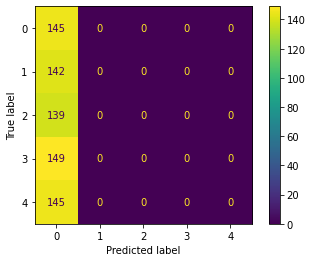

In [68]:
cm = evaluate_reg(y_train_new,y_pred_train)

c:\Users\EGYPT_LAPTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EGYPT_LAPTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EGYPT_LAPTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

         0.0       0.19      1.00      0.33        35
         1.0       0.00      0.00      0.00        38
         2.0       0.00      0.00      0.00        41
         3.0       0.00      0.00      0.00        31
         4.0       0.00      0.00      0.00        35

    accuracy                           0.19       180
   macro avg       0.04      0.20      0.07       180
weighted avg       0.04      0.19      0.06       180



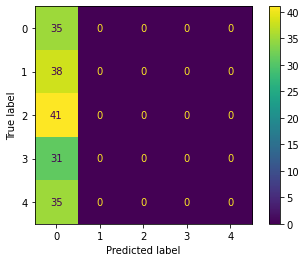

In [69]:
cm = evaluate_reg(y_val_new,y_pred_val)

              precision    recall  f1-score   support

         0.0       0.20      1.00      0.33        20
         1.0       0.00      0.00      0.00        20
         2.0       0.00      0.00      0.00        20
         3.0       0.00      0.00      0.00        20
         4.0       0.00      0.00      0.00        20

    accuracy                           0.20       100
   macro avg       0.04      0.20      0.07       100
weighted avg       0.04      0.20      0.07       100



c:\Users\EGYPT_LAPTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EGYPT_LAPTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EGYPT_LAPTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

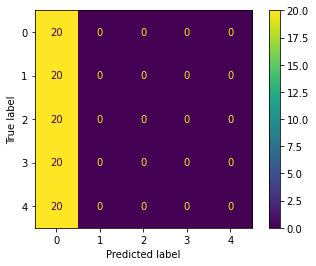

In [70]:
cm = evaluate_reg(y_test_new,y_pred_test)

## Part 2. Improve your Model

Regularization and data augmentation are common strategies to deal with small datasets.


In [31]:
# Write your code here
x = vgg_16.layers[6].output
x = Conv2D(300,3,padding="same",activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(512,3,padding="same",activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(500, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(7, activation='softmax')(x)
vgg_model = Model(inputs=vgg_16.input, outputs=x)

In [33]:
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
history = vgg_model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1,validation_data=(x_val, y_val))

Epoch 1/20
23/23 [==============================] - 72s 3s/step - loss: 0.5730 - accuracy: 0.7931 - val_loss: 2.8444 - val_accuracy: 0.3722
Epoch 2/20
23/23 [==============================] - 68s 3s/step - loss: 0.4386 - accuracy: 0.8556 - val_loss: 2.1883 - val_accuracy: 0.4944
Epoch 3/20
23/23 [==============================] - 68s 3s/step - loss: 0.1562 - accuracy: 0.9583 - val_loss: 3.5028 - val_accuracy: 0.4056
Epoch 4/20
23/23 [==============================] - 68s 3s/step - loss: 0.0908 - accuracy: 0.9792 - val_loss: 3.0535 - val_accuracy: 0.3556
Epoch 5/20
23/23 [==============================] - 70s 3s/step - loss: 0.0466 - accuracy: 0.9931 - val_loss: 2.1292 - val_accuracy: 0.4722
Epoch 6/20
23/23 [==============================] - 68s 3s/step - loss: 0.0384 - accuracy: 0.9903 - val_loss: 1.7320 - val_accuracy: 0.4778
Epoch 7/20
23/23 [==============================] - 55s 2s/step - loss: 0.0219 - accuracy: 0.9972 - val_loss: 1.8082 - val_accuracy: 0.4667
Epoch 8/20
23/23 [==

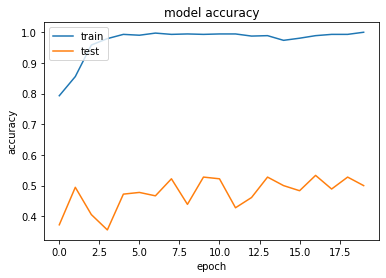

In [34]:
plt_acc(history.history['accuracy'],history.history['val_accuracy'])

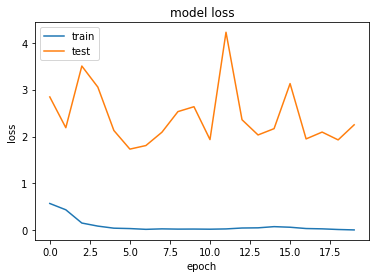

In [35]:
plt_loss(history.history['loss'],history.history['val_loss'])

In [38]:
y_pred_test = vgg_model.predict(x_test)
y_pred_train = vgg_model.predict(x_train)
y_pred_val = vgg_model.predict(x_val)

6/6 [==============================] - 6s 1s/step


              precision    recall  f1-score   support

           1       1.00      0.99      0.99       145
           2       0.99      0.97      0.98       142
           3       1.00      0.98      0.99       139
           4       0.99      0.97      0.98       149
           6       0.93      1.00      0.96       145

    accuracy                           0.98       720
   macro avg       0.98      0.98      0.98       720
weighted avg       0.98      0.98      0.98       720



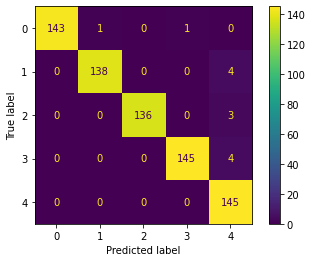

In [40]:
cm = evaluate(y_train,y_pred_train)

              precision    recall  f1-score   support

           1       0.84      0.74      0.79        35
           2       0.60      0.47      0.53        38
           3       0.50      0.20      0.28        41
           4       0.36      0.26      0.30        31
           6       0.37      0.86      0.52        35

    accuracy                           0.50       180
   macro avg       0.53      0.51      0.48       180
weighted avg       0.54      0.50      0.48       180



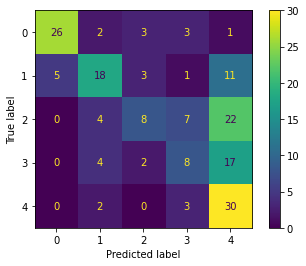

In [41]:
cm = evaluate(y_val,y_pred_val)

              precision    recall  f1-score   support

           1       0.65      0.55      0.59        20
           2       0.39      0.35      0.37        20
           3       0.38      0.30      0.33        20
           4       0.50      0.10      0.17        20
           6       0.40      0.90      0.55        20

    accuracy                           0.44       100
   macro avg       0.46      0.44      0.40       100
weighted avg       0.46      0.44      0.40       100



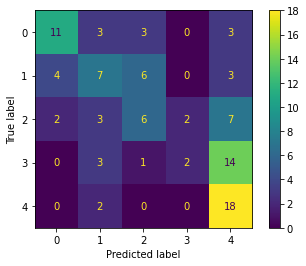

In [42]:
cm = evaluate(y_test,y_pred_test)

In [43]:
datagen = ImageDataGenerator(rotation_range=45,
        height_shift_range=0.2,
        width_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [45]:
train = datagen.flow(x_train,y_train,seed=42)
val = datagen.flow(x_val,y_val,seed=42)
history = vgg_model.fit_generator(train,epochs= 50,validation_data = val)

C:\Users\EGYPT_LAPTOP\AppData\Local\Temp\ipykernel_13052\1477132933.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = vgg_model.fit_generator(train,epochs= 50,validation_data = val)


Epoch 1/50
23/23 [==============================] - 427s 18s/step - loss: 0.7455 - accuracy: 0.6653 - val_loss: 1.8598 - val_accuracy: 0.5000
Epoch 2/50
23/23 [==============================] - 62s 3s/step - loss: 0.7668 - accuracy: 0.6792 - val_loss: 3.6275 - val_accuracy: 0.4611
Epoch 3/50
23/23 [==============================] - 60s 3s/step - loss: 0.8283 - accuracy: 0.6625 - val_loss: 2.2253 - val_accuracy: 0.4333
Epoch 4/50
23/23 [==============================] - 62s 3s/step - loss: 0.8485 - accuracy: 0.6458 - val_loss: 1.4287 - val_accuracy: 0.4889
Epoch 5/50
23/23 [==============================] - 60s 3s/step - loss: 0.7394 - accuracy: 0.6875 - val_loss: 1.2226 - val_accuracy: 0.5389
Epoch 6/50
23/23 [==============================] - 70s 3s/step - loss: 0.6960 - accuracy: 0.7139 - val_loss: 1.1803 - val_accuracy: 0.5333
Epoch 7/50
23/23 [==============================] - 72s 3s/step - loss: 0.7039 - accuracy: 0.7014 - val_loss: 0.9050 - val_accuracy: 0.6667
Epoch 8/50
23/23 [

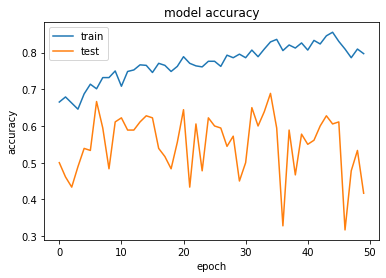

In [46]:
plt_acc(history.history['accuracy'],history.history['val_accuracy'])

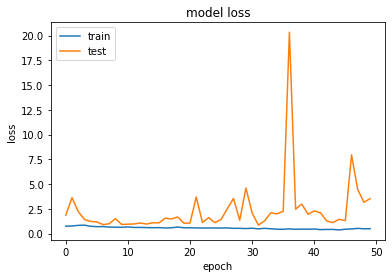

In [47]:
plt_loss(history.history['loss'],history.history['val_loss'])

In [48]:
y_pred_test = vgg_model.predict(x_test)
y_pred_train = vgg_model.predict(x_train)
y_pred_val = vgg_model.predict(x_val)

6/6 [==============================] - 7s 1s/step


c:\Users\EGYPT_LAPTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EGYPT_LAPTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EGYPT_LAPTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.38      0.95      0.54       145
           2       0.94      0.23      0.36       142
           3       0.56      0.43      0.49       139
           4       0.78      0.38      0.51       149
           5       0.00      0.00      0.00         0
           6       0.78      0.67      0.72       145

    accuracy                           0.53       720
   macro avg       0.49      0.38      0.37       720
weighted avg       0.69      0.53      0.52       720



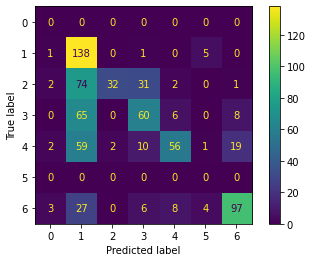

In [49]:
cm = evaluate(y_train,y_pred_train)

c:\Users\EGYPT_LAPTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EGYPT_LAPTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EGYPT_LAPTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.31      0.97      0.47        35
           2       0.83      0.13      0.23        38
           3       0.35      0.20      0.25        41
           4       0.50      0.29      0.37        31
           5       0.00      0.00      0.00         0
           6       0.67      0.34      0.45        35

    accuracy                           0.38       180
   macro avg       0.38      0.28      0.25       180
weighted avg       0.53      0.38      0.35       180



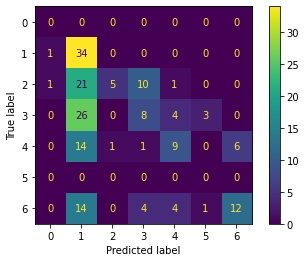

In [50]:
cm = evaluate(y_val,y_pred_val)

              precision    recall  f1-score   support

           1       0.32      0.90      0.47        20
           2       1.00      0.05      0.10        20
           3       0.33      0.30      0.32        20
           4       0.33      0.10      0.15        20
           5       0.00      0.00      0.00         0
           6       0.64      0.45      0.53        20

    accuracy                           0.36       100
   macro avg       0.44      0.30      0.26       100
weighted avg       0.53      0.36      0.31       100



c:\Users\EGYPT_LAPTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EGYPT_LAPTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EGYPT_LAPTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

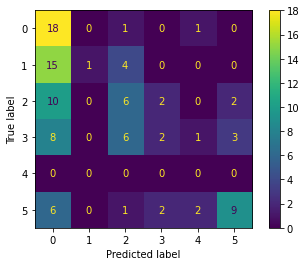

In [51]:
cm = evaluate(y_test,y_pred_test)

## References
[1] N. Teimouri, M. Dyrmann, P. R. Nielsen, S. K. Mathiassen, G. J. Somerville, and R. N. Jørgensen, “Weed growth stage estimator using deep convolutional neural networks,” Sensors, vol. 18, no. 5, 2018.